In [1]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Analyze External Data in BigQuery from Cloud SQL and Spanner**





<table align="left">
<td style="text-align: center">
<a href="https://colab.research.google.com/github/mfreke-udoka/notebook-gallery/blob/main/bigquery/bq_federated_query_cloudsql_spanner.ipynb">
<img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
</a>
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fmfreke-udoka%2Fnotebook-gallery%2Fmain%2Fbigquery%2Fbq_federated_query_cloudsql_spanner.ipynb">
<img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
</a>
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/mfreke-udoka/notebook-gallery/main/bigquery/bq_federated_query_cloudsql_spanner.ipynb">
<img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
</a>
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/mfreke-udoka/notebook-gallery/blob/main/bigquery/bq_federated_query_cloudsql_spanner.ipynb">
<img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
</a>
</td>
<td style="text-align: center">
<a href="https://github.com/mfreke-udoka/notebook-gallery/blob/main/bigquery/bq_federated_query_cloudsql_spanner.ipynb">
<img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
</a>
</td>
</table>

<div style="clear: both;"></div>

| Author |
| --- |
| [Mfreke Udoka](https://github.com/mfreke-udoka) |

## **Overview**

This notebook offers a comprehensive, modular template for querying data from external data sources within a Google Cloud notebook environment. It is designed to be adaptable and can be run in BigQuery Notebooks, Vertex AI Workbench, or Google Colab.


### Objectives

* **Primary Objective:** Demonstrate how to establish a federated connection from BigQuery to Cloud SQL (MySQL) and Cloud Spanner.

* Provide end-to-end, runnable code to create, load, and query both Cloud SQL and Spanner instances.

* Illustrate how to execute a complex federated query that joins data simultaneously from a native BigQuery table, Cloud SQL, and Cloud Spanner.

###Services and Costs
This tutorial uses the following billable components of Google Cloud:

*   BigQuery: [Pricing](https://cloud.google.com/bigquery/pricing)

*   Cloud SQL: [Pricing](https://cloud.google.com/sql/pricing)

*   Cloud Spanner: [Pricing](https://cloud.google.com/spanner/pricing)

*   Cloud Storage: [Pricing](https://cloud.google.com/storage/pricing)

You can use the [Pricing Calculator](https://cloud.google.com/products/calculator) to generate a cost estimate based on your projected usage. Remember to run the cleanup steps at the end to avoid ongoing charges.

**Note: some of the components are used only if you run the optional setup sections**

### About the Dataset

This template uses the public `bigquery-public-data.google_analytics_sample` dataset, which contains obfuscated Google Analytics 360 data from the Google Merchandise Store. To demonstrate federated queries across different sources and time periods, the data is split as follows:

* **Cloud SQL (MySQL):** Contains data for **July 2017**.

* **Cloud Spanner:** Contains data for **June 2017**.

* **Native BigQuery Table:** Contains data for **May 2017**.

This allows the final federated query in Part 3 to join data across all three months and sources.

### Execution Options

This guide is split into independent workflows:

* **Part 1:** Connects BigQuery to a **Cloud SQL for MySQL** instance.

* **Part 2:** Connects BigQuery to a **Cloud Spanner** instance.

* **Part 3:** Demonstrates a **federated query** joining data from native BigQuery tables, Cloud SQL, and Spanner simultaneously (requires completing Parts 1 and 2).

You can run Part 1 or Part 2 independently, or run all parts for a complete federated data example. Each part includes optional steps to create and configure the necessary database environment from scratch.

---

## **Prerequisites: Google Cloud Project Setup**

Before running the code in this notebook, please complete the following steps in the Google Cloud Console:

1. **[Select or create a Google Cloud project.](https://console.cloud.google.com/cloud-resource-manager)** When you first create an account, you get a free credit towards your compute and storage costs.

2. **[Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).** The operations in this notebook (e.g., creating Cloud SQL and Spanner instances) require a project with active billing.

3. **Note on APIs:** The notebook code will automatically enable the necessary APIs (e.g., BigQuery, Cloud SQL, Spanner, etc.) as you run the cells.

---

## **Prepare Your Environment (Common Steps)**

### 1. Environment-Specific Setup

Complete the setup steps for your specific notebook environment.

* **For BigQuery or Vertex AI Workbench Users:** Your environment is pre-configured with the necessary tools and authentication. You can proceed directly to the next step.

* **For Google Colab Users:** In Colab, you must first authenticate your user and install the `gcloud` CLI and `jq`. The cells below will detect if you are in a Colab environment and run the necessary setup commands.

In [2]:
import os
import sys

# This check is designed to run only in a true Google Colab environment.
# BigQuery and Vertex AI notebooks may have 'google.colab' in sys.modules,
# so we also check for the absence of a GCP-specific environment variable.
IS_COLAB = 'google.colab' in sys.modules and not os.environ.get('DATALAB_SETTINGS_OVERRIDES')

if IS_COLAB:
    print("Colab environment detected. Authenticating user...")
    from google.colab import auth
    auth.authenticate_user()
    print('Authenticated.')
else:
    print("Non-Colab environment detected (BigQuery, Vertex AI, or local). Skipping Colab-specific authentication.")

Colab environment detected. Authenticating user...
Authenticated.


In [3]:
import os
import sys

# This check is designed to run only in a true Google Colab environment.
IS_COLAB = 'google.colab' in sys.modules and not os.environ.get('DATALAB_SETTINGS_OVERRIDES')

if IS_COLAB:
    # Install gcloud CLI and jq for shell commands
    print('\nInstalling command-line tools...')
    !echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | tee /etc/apt/sources.list.d/google-cloud-sdk.list
    !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key --keyring /usr/share/keyrings/cloud.google.gpg add -
    !apt-get -qq update && apt-get -qq install -y google-cloud-sdk jq
    print('Tools installed.')
else:
    print("Non-Colab environment detected (BigQuery, Vertex AI, or local). Skipping tool installation.")


Installing command-line tools...
deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   3866      0 --:--:-- --:--:-- --:--:--  3871
OK
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Tools installed.


### 2. Set Common Project Environment Variables

This cell contains configurations that are shared across all parts of the notebook.

In [4]:

# --- Shared Configuration ---
# ⚠️ **ACTION REQUIRED**: Replace with your Google Cloud project ID.
PROJECT_ID="arg-dev-mu" # @param {type:"string"}

# --- Optional Configuration ---
# You can change the location, but ensure it's a region that supports all
# services used in this notebook (BigQuery, Cloud SQL, Spanner).
LOCATION="us-central1" # @param {type:"string"}

# --- Set environment variables for shell commands ---
os.environ['PROJECT_ID'] = PROJECT_ID
os.environ['LOCATION'] = LOCATION

# --- Set gcloud project config ---
# This ensures shell commands in the notebook target the correct project
print(f"Setting gcloud project to {PROJECT_ID}...")
!gcloud config set project {PROJECT_ID}

Setting gcloud project to arg-dev-mu...
Updated property [core/project].


### 3. Enable Common APIs

Ensures the core services used in all workflows are enabled.

In [5]:
print("Enabling common Google Cloud APIs...")
!gcloud services enable bigquery.googleapis.com storage.googleapis.com bigqueryconnection.googleapis.com
print("APIs enabled.")

Enabling common Google Cloud APIs...
Operation "operations/acat.p2-472369021765-33e20a75-218e-4058-852e-d0b9c2162889" finished successfully.
APIs enabled.


### 4. Configure Service Account Permissions (Overview)

**Note:** The permissions detailed in the following sections are **only required if you intend to run the optional "Setup" steps** to create new cloud resources. The specific roles needed are listed within each of those optional sections for clarity.



**Identify the correct identity to grant permissions to:**

* **For BigQuery/Vertex AI:** This is the service account associated with the notebook. You can find this in the notebook's details panel.

* **For Colab:** This is the user account you authenticated with in the first setup cell (e.g., your-email@gmail.com).

**Required Roles & Example Commands:**

Below are the roles required to run the optional "Setup" sections. Replace YOUR_PROJECT_ID and YOUR_IDENTITY (e.g., user:your-email@gmail.com or serviceAccount:your-sa@project.iam.gserviceaccount.com) in the example gcloud commands.

*   **For Part 1 (Cloud SQL Setup)**

    ```
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/cloudsql.admin"
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/storage.admin"
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/bigquery.admin"
    ```


*  **For Part 2 (Spanner Setup):**

    ```
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/spanner.databaseAdmin"
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/bigquery.admin"
    ```


*   **For Part 3 (BigQuery Dataset Creation):**

    ```
    gcloud projects add-iam-policy-binding YOUR_PROJECT_ID --member="YOUR_IDENTITY" --role="roles/bigquery.dataEditor"
    ```

---

## **Part 1: Connect BigQuery to Cloud SQL (End-to-End Workflow)**

This part provides a complete workflow for setting up, loading, and querying a Cloud SQL for MySQL database from BigQuery.


### 1.1 Cloud SQL Configuration

Set the variables for the Cloud SQL workflow.

In [6]:
import os

# --- Optional Configuration ---
# These variables define the names for the new resources that will be created.
# You can leave them as-is or customize them.
MYSQL_INSTANCE="cloudsql-mysql-instance" # @param {type:"string"}
MYSQL_DATABASE="cloudsql-mysql-db" # @param {type:"string"}
CLOUDSQL_USER="User1" # @param {type:"string"}
BQ_CLOUDSQL_CONNECTION="bq-cloudsql-connection" # @param {type:"string"}

# ⚠️ **ACTION REQUIRED**: Provide strong passwords for the database users.
DB_ROOT_PASSWORD="mhhdauy&&92!" # @param {type:"string"}
CLOUDSQL_PASSWORD="Y7hsjal9821" # @param {type:"string"}

# --- No changes needed below this line ---
# These variables are derived from the settings above or are fixed for this template.
GCS_IMPORT_BUCKET=f"gs://{PROJECT_ID}-bq-federation-template-bucket/"
MYSQL_TABLE="ga_sessions_201707"
MYSQL_PRODUCTS_TABLE="ga_product_hits_201707"

# --- Set environment variables for this section ---
os.environ['GCS_IMPORT_BUCKET'] = GCS_IMPORT_BUCKET
os.environ['MYSQL_INSTANCE'] = MYSQL_INSTANCE
os.environ['DB_ROOT_PASSWORD'] = DB_ROOT_PASSWORD
os.environ['MYSQL_DATABASE'] = MYSQL_DATABASE
os.environ['MYSQL_TABLE'] = MYSQL_TABLE
os.environ['MYSQL_PRODUCTS_TABLE'] = MYSQL_PRODUCTS_TABLE
os.environ['CLOUDSQL_USER'] = CLOUDSQL_USER
os.environ['CLOUDSQL_PASSWORD'] = CLOUDSQL_PASSWORD
os.environ['BQ_CLOUDSQL_CONNECTION'] = BQ_CLOUDSQL_CONNECTION

### 1.2 Enable Cloud SQL API
This command ensures that the Cloud SQL Admin API is enabled in your project, allowing you to manage Cloud SQL instances programmatically.

In [7]:
print("Enabling the Cloud SQL Admin API...")
!gcloud services enable sqladmin.googleapis.com
print("API enabled.")

Enabling the Cloud SQL Admin API...
API enabled.


### 1.3 Service Account Permissions for Cloud SQL Workflow

Grant your notebook's identity the following roles:

* **To run the full setup (including optional steps):** `roles/cloudsql.admin`, `roles/storage.admin`, `roles/bigquery.admin`. The `roles/bigquery.admin` role includes permissions to query the public Google Analytics dataset used in the data loading steps.

* **To connect to an existing instance (skipping optional steps):** `roles/bigquery.connectionAdmin`, `roles/bigquery.user`.



### 1.4 Setup Cloud SQL Environment (Optional)

Complete this section to create a new Cloud SQL instance and load it with data.

**Permissions Note:** To run the setup steps in this section, the identity executing the notebook needs the following roles: `Cloud SQL Admin`, `Storage Admin`, and `BigQuery Admin`.

#### Create GCS Bucket

This temporary bucket is used to hold the CSV file before importing it to Cloud SQL.

In [8]:
print(f"Checking for GCS bucket {GCS_IMPORT_BUCKET}...")
import subprocess
# Use gsutil to check for the bucket's existence.
bucket_check = subprocess.run(f"gsutil ls {GCS_IMPORT_BUCKET}", shell=True, capture_output=True)

if bucket_check.returncode != 0:
    print(f"Bucket not found. Creating it...")
    !gcloud storage buckets create {GCS_IMPORT_BUCKET} --project={PROJECT_ID} --location={LOCATION} --uniform-bucket-level-access
else:
    print(f"Bucket {GCS_IMPORT_BUCKET} already exists.")

Checking for GCS bucket gs://arg-dev-mu-bq-federation-template-bucket/...
Bucket gs://arg-dev-mu-bq-federation-template-bucket/ already exists.


#### Create Cloud SQL Instance and Database

This cell creates the Cloud SQL instance and a database within it. This step can take several minutes.

In [9]:
# Create a small Cloud SQL for MySQL instance
print(f"Creating Cloud SQL instance '{MYSQL_INSTANCE}'... This may take a few minutes.")

!gcloud sql instances create {MYSQL_INSTANCE} \
    --database-version=MYSQL_8_0 \
    --tier=db-n1-standard-1 \
    --region={LOCATION} \
    --root-password="{DB_ROOT_PASSWORD}"

# Create the MySQL database within the new instance
print(f"\nCreating MySQL database '{MYSQL_DATABASE}'...")
!gcloud sql databases create {MYSQL_DATABASE} --instance={MYSQL_INSTANCE}
print("Cloud SQL instance and database created.")

Creating Cloud SQL instance 'cloudsql-mysql-instance'... This may take a few minutes.
Created [https://sqladmin.googleapis.com/sql/v1beta4/projects/arg-dev-mu/instances/cloudsql-mysql-instance].
NAME                     DATABASE_VERSION  LOCATION       TIER              PRIMARY_ADDRESS  PRIVATE_ADDRESS  STATUS
cloudsql-mysql-instance  MYSQL_8_0         us-central1-c  db-n1-standard-1  34.133.8.71      -                RUNNABLE

Creating MySQL database 'cloudsql-mysql-db'...
Created database [cloudsql-mysql-db].
instance: cloudsql-mysql-instance
name: cloudsql-mysql-db
project: arg-dev-mu
Cloud SQL instance and database created.


#### Install Python Libraries for Cloud SQL Setup

These libraries are needed to connect to the database and process the data.

In [10]:
# Detect if the notebook is running in Colab to install specific package versions.
import sys
IN_COLAB = 'google.colab' in sys.modules

print("Installing Python libraries for Cloud SQL...")
if IN_COLAB:
    print("Colab environment detected. Installing pinned versions...")
    # NOTE: These versions are pinned to match the pre-installed packages in Colab.
    # If you encounter a dependency mismatch error, check the error message for the
    # new required version of pandas or fsspec and update the command below.
    %pip install --upgrade --quiet cloud-sql-python-connector PyMySQL google-cloud-bigquery sqlalchemy pandas==2.2.2 gcsfs fsspec==2025.3.0
else:
    print("Non-Colab environment detected. Installing latest versions...")
    # In BigQuery or Vertex AI, install the latest versions.
    %pip install --upgrade --quiet cloud-sql-python-connector PyMySQL google-cloud-bigquery sqlalchemy pandas gcsfs

print("Libraries installed.")

Installing Python libraries for Cloud SQL...
Colab environment detected. Installing pinned versions...
Libraries installed.


#### Create Cloud SQL Tables

This step defines the table schemas. The Google Analytics data has a one-to-many relationship: a single user session can have interactions with multiple products. To model this efficiently in a relational database like MySQL, we normalize the data into two tables:

*   **ga_sessions_201707:** This is the "parent" table, containing one row for each unique user session.

*   **ga_product_hits_201707:** This is the "child" table, containing one row for each product that was viewed, clicked, or purchased during a session. It links back to the parent session table.

In [11]:
import sqlalchemy
from google.cloud.sql.connector import Connector

def setup_mysql_user_and_tables():
    """A single function to handle user creation, table creation, and indexing."""
    instance_connection_name = f"{PROJECT_ID}:{LOCATION}:{MYSQL_INSTANCE}"
    connector = Connector()

    # Connect as root to create the dedicated user and grant permissions.
    def get_root_conn():
        return connector.connect(
            instance_connection_name, "pymysql", user="root",
            password=DB_ROOT_PASSWORD, db=MYSQL_DATABASE
        )
    root_pool = sqlalchemy.create_engine("mysql+pymysql://", creator=get_root_conn)

    try:
        with root_pool.connect() as db_conn:
            print(f"Creating database user '{CLOUDSQL_USER}'...")
            db_conn.execute(sqlalchemy.text(f"CREATE USER IF NOT EXISTS '{CLOUDSQL_USER}'@'%' IDENTIFIED BY '{CLOUDSQL_PASSWORD}';"))
            db_conn.execute(sqlalchemy.text(f"GRANT ALL PRIVILEGES ON `{MYSQL_DATABASE}`.* TO '{CLOUDSQL_USER}'@'%';"))
            db_conn.commit()
            print(f"Successfully created user.")
    except Exception as e:
        print(f"An error occurred during user creation: {e}")
        return

    # Connect as the new user to create tables.
    def get_app_conn():
        return connector.connect(
            instance_connection_name, "pymysql", user=CLOUDSQL_USER,
            password=CLOUDSQL_PASSWORD, db=MYSQL_DATABASE
        )
    app_pool = sqlalchemy.create_engine("mysql+pymysql://", creator=get_app_conn)

    create_sessions_stmt = sqlalchemy.text(f"""
        CREATE TABLE IF NOT EXISTS `{MYSQL_TABLE}` (
            fullVisitorId VARCHAR(255), visitId INT, visitNumber INT, visitStartTime INT,
            `date` DATE, totals JSON, trafficSource JSON, device JSON, geoNetwork JSON,
            channelGrouping VARCHAR(255), PRIMARY KEY (fullVisitorId(50), visitId)
        )
    """)
    create_products_stmt = sqlalchemy.text(f"""
        CREATE TABLE IF NOT EXISTS `{MYSQL_PRODUCTS_TABLE}` (
            fullVisitorId VARCHAR(255), visitId INT, v2ProductName VARCHAR(255), productRevenue BIGINT
        )
    """)

    try:
        with app_pool.connect() as db_conn:
            print("Creating tables...")
            db_conn.execute(create_sessions_stmt)
            db_conn.execute(create_products_stmt)
            db_conn.commit()
            print("Tables created successfully.")
    except Exception as e:
        print(f"An error occurred during table creation: {e}")
    finally:
        connector.close()

# --- Run the setup function ---
setup_mysql_user_and_tables()

Creating database user 'User1'...
Successfully created user.
Creating tables...
Tables created successfully.


#### Load Data into Cloud SQL Tables (July 2017 Data)

This process queries data from a public BigQuery dataset, exports it to GCS, and imports it into Cloud SQL.

In [12]:
from google.cloud import bigquery
import pandas as pd

# Stage 1: Export BigQuery data to GCS
client = bigquery.Client(project=PROJECT_ID)
source_table_full_id = f"`bigquery-public-data.google_analytics_sample.ga_sessions_201707*`"
sessions_uri = f"{GCS_IMPORT_BUCKET.rstrip('/')}/ga_sessions_201707.csv"
products_uri = f"{GCS_IMPORT_BUCKET.rstrip('/')}/ga_product_hits_201707.csv"

print(f"Reading and unnesting data from {source_table_full_id}...")
sql = f"""
SELECT
    fullVisitorId, visitId, visitNumber, visitStartTime, PARSE_DATE('%Y%m%d', date) as `date`,
    TO_JSON_STRING(totals) as totals, TO_JSON_STRING(trafficSource) as trafficSource,
    TO_JSON_STRING(device) as device, TO_JSON_STRING(geoNetwork) as geoNetwork, channelGrouping,
    product.v2ProductName, product.productRevenue
FROM {source_table_full_id}, UNNEST(hits) as h, UNNEST(h.product) as product
"""
full_df = client.query(sql).to_dataframe()

sessions_df = full_df[['fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime', 'date', 'totals', 'trafficSource', 'device', 'geoNetwork', 'channelGrouping']].drop_duplicates()
products_df = full_df[['fullVisitorId', 'visitId', 'v2ProductName', 'productRevenue']].dropna(subset=['v2ProductName'])

print(f"Writing CSVs to {GCS_IMPORT_BUCKET}...")
sessions_df.to_csv(sessions_uri, index=False, header=False)
products_df.to_csv(products_uri, index=False, header=False)
print("CSVs written successfully.")

# Stage 2: Grant Cloud SQL permissions to GCS bucket
print("\nFetching Cloud SQL service account...")
sa_email_result = !gcloud sql instances describe {MYSQL_INSTANCE} --format='value(serviceAccountEmailAddress)'
sa_email = sa_email_result[0]

print(f"Granting Storage Object Viewer role to {sa_email}...")
!gcloud storage buckets add-iam-policy-binding {GCS_IMPORT_BUCKET} --member="serviceAccount:{sa_email}" --role="roles/storage.objectViewer" --condition=None
print("Permissions granted.")

# Stage 3: Import data from GCS into Cloud SQL
print("\nImporting data into Cloud SQL tables. This may take a few minutes...")
!gcloud sql import csv {MYSQL_INSTANCE} {sessions_uri} --database={MYSQL_DATABASE} --table={MYSQL_TABLE} --quiet
!gcloud sql import csv {MYSQL_INSTANCE} {products_uri} --database={MYSQL_DATABASE} --table={MYSQL_PRODUCTS_TABLE} --quiet
print("\nData import processes initiated. Check status in the cell below.")

Reading and unnesting data from `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`...
Writing CSVs to gs://arg-dev-mu-bq-federation-template-bucket/...
CSVs written successfully.

Fetching Cloud SQL service account...
Granting Storage Object Viewer role to p472369021765-rq48ao@gcp-sa-cloud-sql.iam.gserviceaccount.com...
bindings:
- members:
  - projectEditor:arg-dev-mu
  - projectOwner:arg-dev-mu
  role: roles/storage.legacyBucketOwner
- members:
  - projectViewer:arg-dev-mu
  role: roles/storage.legacyBucketReader
- members:
  - projectEditor:arg-dev-mu
  - projectOwner:arg-dev-mu
  role: roles/storage.legacyObjectOwner
- members:
  - projectViewer:arg-dev-mu
  role: roles/storage.legacyObjectReader
- members:
  - serviceAccount:p472369021765-rq48ao@gcp-sa-cloud-sql.iam.gserviceaccount.com
  - serviceAccount:p472369021765-u221hv@gcp-sa-cloud-sql.iam.gserviceaccount.com
  role: roles/storage.objectViewer
etag: CAM=
kind: storage#policy
resourceId: projects/_/buckets/arg

In [13]:
print("Checking status of recent Cloud SQL operations...")
print("Wait until the status for both IMPORT operations shows as DONE before continuing.")
!gcloud sql operations list --instance={MYSQL_INSTANCE} --limit=5

Checking status of recent Cloud SQL operations...
Wait until the status for both IMPORT operations shows as DONE before continuing.
NAME                                  TYPE             START                          END                            ERROR  STATUS
0d028c77-d47d-423d-808f-098300000032  IMPORT           2025-09-09T21:25:48.972+00:00  2025-09-09T21:25:59.443+00:00  -      DONE
0ffef06b-1fc5-4cca-85c6-841c00000032  IMPORT           2025-09-09T21:25:30.266+00:00  2025-09-09T21:25:40.649+00:00  -      DONE
90f6488c-a69c-4f15-a47d-41c900000032  CREATE_DATABASE  2025-09-09T21:24:36.252+00:00  2025-09-09T21:24:36.330+00:00  -      DONE
26767654-40cb-4710-9edc-8da300000032  CREATE           2025-09-09T21:21:41.844+00:00  2025-09-09T21:24:34.409+00:00  -      DONE


</details>

### 1.5 Establish BigQuery Connection to Cloud SQL

This section creates the BigQuery connection resource, which acts as a secure bridge to your Cloud SQL instance.

In [14]:
print(f"Creating BigQuery connection '{BQ_CLOUDSQL_CONNECTION}'...")

# Define the connection properties and credentials as JSON strings.
properties_json = f'{{"instanceId":"{PROJECT_ID}:{LOCATION}:{MYSQL_INSTANCE}","database":"{MYSQL_DATABASE}","type":"MYSQL"}}'
credential_json = f'{{"username":"{CLOUDSQL_USER}","password":"{CLOUDSQL_PASSWORD}"}}'
connection_id = BQ_CLOUDSQL_CONNECTION

!bq mk --connection \
    --display_name={connection_id} \
    --connection_type=CLOUD_SQL \
    --properties='{properties_json}' \
    --connection_credential='{credential_json}' \
    --project_id={PROJECT_ID} \
    --location={LOCATION} \
    {connection_id}

Creating BigQuery connection 'bq-cloudsql-connection'...
Connection 472369021765.us-central1.bq-cloudsql-connection successfully created


#### Verify the Cloud SQL Connection

The following command shows the details of the connection resource you just created. Note that the `hasCredential` field is `True`, indicating that this connection uses a username and password stored securely within the connection resource itself.

In [15]:
print("Displaying Cloud SQL connection details...")
!bq show --connection {PROJECT_ID}.{LOCATION}.{BQ_CLOUDSQL_CONNECTION}

Displaying Cloud SQL connection details...
Connection arg-dev-mu.us-central1.bq-cloudsql-connection

                       name                              friendlyName        description    Last modified      type      hasCredential                                                                                                      properties                                                                                                     
 ------------------------------------------------- ------------------------ ------------- ----------------- ----------- --------------- ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 
  472369021765.us-central1.bq-cloudsql-connection   bq-cloudsql-connection                 09 Sep 21:26:09   CLOUD_SQL   True            {"instanceId": "arg-dev-mu:us-central1:cloudsql-mysql-instance", "

#### Grant Connection Permissions

The new connection has its own unique service account. This step is crucial as it grants that service account the `Cloud SQL Client` role, which is the permission it needs to access the Cloud SQL instance.

In [16]:
print("Fetching connection's service account and granting permissions...")
# Use bq show with jq to parse the service account ID from the JSON output.
sa_output_list = !bq show --format=json --connection {PROJECT_ID}.{LOCATION}.{BQ_CLOUDSQL_CONNECTION} | jq -r '.cloudSql.serviceAccountId'
connection_sa = sa_output_list[0]

print(f"Connection Service Account: {connection_sa}")
print(f"Granting Cloud SQL Client permission...")

# Grant the connection's service account the "Cloud SQL Client" role on the project.
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:{connection_sa}" \
    --role="roles/cloudsql.client" \
    --quiet

print(f"\nSuccessfully granted connection access to the Cloud SQL instance.")

Fetching connection's service account and granting permissions...
Connection Service Account: service-472369021765@gcp-sa-bigqueryconnection.iam.gserviceaccount.com
Granting Cloud SQL Client permission...
Updated IAM policy for project [arg-dev-mu].
bindings:
- members:
  - serviceAccount:service-472369021765@gcp-sa-vertex-nb.iam.gserviceaccount.com
  role: roles/aiplatform.colabServiceAgent
- members:
  - serviceAccount:service-472369021765@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-472369021765@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - deleted:serviceAccount:bqcx-472369021765-s31q@gcp-sa-bigquery-condel.iam.gserviceaccount.com?uid=100188737858243914141
  role: roles/aiplatform.user
- members:
  - serviceAccount:service-472369021765@gcp-sa-bigqueryconnection.iam.gserviceaccount.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service

### 1.6 Query Cloud SQL Data from BigQuery
The `EXTERNAL_QUERY` function is the core of BigQuery's federation capabilities. It tells BigQuery to send the specified SQL query (the second argument) to the external data source defined by the connection (the first argument). The results are then streamed back to BigQuery to be processed.

In [17]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

# This query will be executed in MySQL via the BigQuery connection.
mysql_query = f"""
    SELECT
        v2ProductName,
        CAST(FLOOR(SUM(productRevenue / 1000000)) AS SIGNED) AS total_product_revenue_USD
    FROM
        {MYSQL_PRODUCTS_TABLE}
    WHERE
        productRevenue IS NOT NULL
    GROUP BY
        v2ProductName
    ORDER BY
        total_product_revenue_USD DESC
    LIMIT 10
"""

# This is the BigQuery SQL that uses EXTERNAL_QUERY to run the MySQL query.
sql = f"""
SELECT
  *
FROM
  EXTERNAL_QUERY(
    'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_CLOUDSQL_CONNECTION}',
    '''{mysql_query}'''
  );
"""

print("Running federated query to find top 10 products by revenue from Cloud SQL...")
df_result_sql = client.query(sql).to_dataframe()

print("Query complete. Top 10 products by revenue (July 2017):")
display(df_result_sql)

Running federated query to find top 10 products by revenue from Cloud SQL...
Query complete. Top 10 products by revenue (July 2017):


,v2ProductName,total_product_revenue_USD
0,Google Baby Essentials Set,5570
1,YouTube Hard Cover Journal,5559
2,Google Hard Cover Journal,5133
3,Google Spiral Journal with Pen,4940
4,Google Sunglasses,4718
5,Leatherette Journal,4660
6,Google 22 oz Water Bottle,4399
7,Google Men's 100% Cotton Short Sleeve Hero Tee...,4075
8,Sport Bag,3183
9,Recycled Paper Journal Set,2960


---

## **Part 2: Connect BigQuery to Spanner (End-to-End Workflow)**

This part provides a complete workflow for setting up, loading, and querying a Spanner database from BigQuery.



### 2.1 Spanner Configuration

In [18]:
import os

# --- Optional Configuration ---
# These variables define the names for the new Spanner resources that will be created.
# You can leave them as-is or customize them.
SPANNER_INSTANCE="spanner-instance-template" # @param {type:"string"}
SPANNER_DATABASE="spanner-db-template" # @param {type:"string"}
BQ_SPANNER_CONNECTION="bq-spanner-connection" # @param {type:"string"}

# --- No changes needed below this line ---
# These variables are derived from the settings above or are fixed for this template.
SPANNER_SESSIONS_TABLE="ga_sessions_201706"
SPANNER_PRODUCTS_TABLE="ga_product_hits_201706"
SPANNER_CONFIG=f"regional-{LOCATION}"

# --- Set environment variables for this section ---
os.environ['SPANNER_INSTANCE'] = SPANNER_INSTANCE
os.environ['SPANNER_DATABASE'] = SPANNER_DATABASE
os.environ['SPANNER_SESSIONS_TABLE'] = SPANNER_SESSIONS_TABLE
os.environ['SPANNER_PRODUCTS_TABLE'] = SPANNER_PRODUCTS_TABLE
os.environ['SPANNER_CONFIG'] = SPANNER_CONFIG
os.environ['BQ_SPANNER_CONNECTION'] = BQ_SPANNER_CONNECTION

### 2.2 Enable Spanner API
This command ensures that the Spanner API is enabled, allowing you to create and manage Spanner instances and databases.

In [19]:
print("Enabling the Spanner API...")
!gcloud services enable spanner.googleapis.com
print("API enabled.")

Enabling the Spanner API...
API enabled.


### 2.3 Service Account Permissions for Spanner Workflow

Grant your notebook's identity the following roles:

* **To run the full setup (including optional steps):** `roles/spanner.databaseAdmin`, `roles/bigquery.admin`. The `roles/bigquery.admin` role includes permissions to query the public Google Analytics dataset used in the data loading steps.

* **To connect to an existing instance (skipping optional steps):** `roles/bigquery.connectionAdmin`, `roles/bigquery.user`, `roles/spanner.databaseUser`.



### 2.4 Setup Spanner Environment (Optional)

Complete the steps below to create a new Spanner instance and load it with data.

**Permissions Note:** To run the setup steps in this section, the identity executing the notebook needs the following roles: `Spanner Database Admin` and `BigQuery Admin`

#### Create Spanner instance and Database

This step can take several minutes.

In [20]:
print(f"Creating Spanner instance '{SPANNER_INSTANCE}'... This may take a few minutes.")
!gcloud spanner instances create {SPANNER_INSTANCE} \
    --config={SPANNER_CONFIG} \
    --description="Spanner Template Instance" \
    --nodes=1

print(f"\nCreating Spanner database '{SPANNER_DATABASE}'...")
!gcloud spanner databases create {SPANNER_DATABASE} --instance={SPANNER_INSTANCE}
print("Spanner instance and database created.")

Creating Spanner instance 'spanner-instance-template'... This may take a few minutes.

Creating Spanner database 'spanner-db-template'...
Spanner instance and database created.


#### Install Python Libraries for Spanner Setup

In [21]:
# Detect if the notebook is running in Colab to install a specific pandas version.
import sys
IN_COLAB = 'google.colab' in sys.modules

print("Installing Python libraries for Spanner...")
if IN_COLAB:
    print("Colab environment detected. Installing pinned versions...")
    %pip install --upgrade --quiet google-cloud-spanner google-cloud-bigquery pandas==2.2.2
else:
    print("Non-Colab environment detected. Installing latest versions...")
    %pip install --upgrade --quiet google-cloud-spanner google-cloud-bigquery pandas

print("Libraries installed.")

Installing Python libraries for Spanner...
Colab environment detected. Installing pinned versions...
Libraries installed.


#### Create Spanner Tables
This step defines the table schemas. The Google Analytics data has a one-to-many relationship: a single user session can have interactions with multiple products. To model this efficiently, we use two tables.

A key feature of Spanner is the ability to interleave tables. We define `ga_product_hits_201706` as interleaved in the parent `ga_sessions_201706` table. This tells Spanner to physically co-locate the child product rows with their parent session row. This dramatically improves the performance of joins between the two tables.

In [22]:
from google.cloud import spanner

def create_spanner_tables():
    """Defines and creates the necessary tables in the Spanner database."""
    spanner_client = spanner.Client(project=PROJECT_ID)
    instance = spanner_client.instance(SPANNER_INSTANCE)
    database = instance.database(SPANNER_DATABASE)

    ddl_statements = [
        f"""
        CREATE TABLE {SPANNER_SESSIONS_TABLE} (
            fullVisitorId   STRING(MAX) NOT NULL,
            visitId         INT64 NOT NULL,
            visitNumber     INT64,
            visitStartTime  INT64,
            date            DATE,
            totals          JSON,
            trafficSource   JSON,
            device          JSON,
            geoNetwork      JSON,
            channelGrouping STRING(MAX),
        ) PRIMARY KEY (fullVisitorId, visitId)
        """,
        f"""
        CREATE TABLE {SPANNER_PRODUCTS_TABLE} (
            fullVisitorId   STRING(MAX) NOT NULL,
            visitId         INT64 NOT NULL,
            v2ProductName   STRING(MAX),
            productRevenue  INT64,
        ) PRIMARY KEY (fullVisitorId, visitId, v2ProductName),
        INTERLEAVE IN PARENT {SPANNER_SESSIONS_TABLE} ON DELETE CASCADE
        """
    ]

    print("Creating Spanner tables... This may take a few minutes.")
    try:
        operation = database.update_ddl(ddl_statements)
        print("Waiting for operation to complete...")
        operation.result()  # Blocks until the DDL operation is done.
        print("Tables created successfully.")
    except Exception as e:
        if "Duplicate name" in str(e):
             print("Tables already exist.")
        else:
            print(f"An error occurred during table creation: {e}")

create_spanner_tables()

Creating Spanner tables... This may take a few minutes.
Waiting for operation to complete...
Tables created successfully.


#### Load Data into Spanner Tables (June 2017 Data)

The process for loading data into Spanner is slightly different from Cloud SQL. Instead of staging data in GCS, we load it directly from a pandas DataFrame in the notebook's memory.

*   **Extract & Transform:** Just like before, we use a single SQL query to efficiently transform the data inside BigQuery.

*   **Load to Memory:** The transformed data is loaded into a pandas DataFrame.

*   **Write to Spanner:** We use the Spanner client library to write the DataFrame's contents to the database. This is done in small batches or "chunks" to avoid exceeding Spanner's transaction size and mutation limits, which is a best practice for loading large datasets.

In [23]:
from google.cloud import bigquery, spanner
import pandas as pd

# Query data from BigQuery into Pandas
client = bigquery.Client(project=PROJECT_ID)
source_table_full_id = f"`bigquery-public-data.google_analytics_sample.ga_sessions_201706*`"

print(f"Reading and unnesting data from {source_table_full_id}...")
sql = f"""
SELECT
    fullVisitorId, visitId, visitNumber, visitStartTime, PARSE_DATE('%Y%m%d', date) as `date`,
    TO_JSON_STRING(totals) as totals, TO_JSON_STRING(trafficSource) as trafficSource,
    TO_JSON_STRING(device) as device, TO_JSON_STRING(geoNetwork) as geoNetwork, channelGrouping,
    product.v2ProductName, product.productRevenue
FROM {source_table_full_id}, UNNEST(hits) as h, UNNEST(h.product) as product
"""
full_df = client.query(sql).to_dataframe()

# Split into two dataframes and handle data types for Spanner
session_columns = ['fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime', 'date', 'totals', 'trafficSource', 'device', 'geoNetwork', 'channelGrouping']
sessions_df = full_df[session_columns].drop_duplicates(subset=['fullVisitorId', 'visitId']).astype({'visitId': 'int64', 'visitNumber': 'int64', 'visitStartTime': 'int64'})

products_df = full_df[['fullVisitorId', 'visitId', 'v2ProductName', 'productRevenue']].dropna(subset=['v2ProductName'])
products_df['productRevenue'] = products_df['productRevenue'].fillna(0)
products_df = products_df.astype({'visitId': 'int64', 'productRevenue': 'int64'})
products_df = products_df.drop_duplicates(subset=['fullVisitorId', 'visitId', 'v2ProductName'])

# Load data into Spanner
spanner_client = spanner.Client(project=PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE)
database = instance.database(SPANNER_DATABASE)

def load_data_in_chunks(table_id, df, chunk_size=5000):
    """Writes a DataFrame to the specified Spanner table in chunks to avoid mutation limits."""
    print(f"Loading data into {table_id}...")
    total_rows = len(df)
    for i in range(0, total_rows, chunk_size):
        chunk_df = df.iloc[i:i + chunk_size]
        print(f"  Loading rows {i+1} to {min(i + chunk_size, total_rows)} of {total_rows}...")
        with database.batch() as batch:
            # Using insert_or_update makes the load operation idempotent.
            batch.insert_or_update(
                table=table_id,
                columns=chunk_df.columns,
                values=chunk_df.values.tolist(),
            )
    print(f"Successfully loaded {total_rows} rows into {table_id}.")

load_data_in_chunks(SPANNER_SESSIONS_TABLE, sessions_df)
load_data_in_chunks(SPANNER_PRODUCTS_TABLE, products_df)


Reading and unnesting data from `bigquery-public-data.google_analytics_sample.ga_sessions_201706*`...
Loading data into ga_sessions_201706...
  Loading rows 1 to 5000 of 41566...


Created multiplexed session.
INFO:projects/arg-dev-mu/instances/spanner-instance-template/databases/spanner-db-template:Created multiplexed session.


  Loading rows 5001 to 10000 of 41566...
  Loading rows 10001 to 15000 of 41566...
  Loading rows 15001 to 20000 of 41566...
  Loading rows 20001 to 25000 of 41566...
  Loading rows 25001 to 30000 of 41566...
  Loading rows 30001 to 35000 of 41566...
  Loading rows 35001 to 40000 of 41566...
  Loading rows 40001 to 41566 of 41566...
Successfully loaded 41566 rows into ga_sessions_201706.
Loading data into ga_product_hits_201706...
  Loading rows 1 to 5000 of 779611...
  Loading rows 5001 to 10000 of 779611...
  Loading rows 10001 to 15000 of 779611...
  Loading rows 15001 to 20000 of 779611...
  Loading rows 20001 to 25000 of 779611...
  Loading rows 25001 to 30000 of 779611...
  Loading rows 30001 to 35000 of 779611...
  Loading rows 35001 to 40000 of 779611...
  Loading rows 40001 to 45000 of 779611...
  Loading rows 45001 to 50000 of 779611...
  Loading rows 50001 to 55000 of 779611...
  Loading rows 55001 to 60000 of 779611...
  Loading rows 60001 to 65000 of 779611...
  Loading ro

</details>

### 2.5 Establish BigQuery Connection to Spanner

In [24]:
print(f"Creating BigQuery connection '{BQ_SPANNER_CONNECTION}'...")

# The database property needs the full resource path for Spanner.
db_path = f"projects/{PROJECT_ID}/instances/{SPANNER_INSTANCE}/databases/{SPANNER_DATABASE}"
properties_json = f'{{"database":"{db_path}"}}'
connection_id = BQ_SPANNER_CONNECTION

!bq mk --connection \
    --display_name={connection_id} \
    --connection_type=CLOUD_SPANNER \
    --properties='{properties_json}' \
    --project_id={PROJECT_ID} \
    --location={LOCATION} \
    {connection_id}

print("\nConnection resource created.")

Creating BigQuery connection 'bq-spanner-connection'...
Connection 472369021765.us-central1.bq-spanner-connection successfully created

Connection resource created.


#### Verify the Spanner Connection

The following command shows the details of the Spanner connection. Note that the `hasCredential` field is `False`. This is because Spanner connections use the identity of the connection's service account to authenticate, rather than a stored username and password.

In [25]:
print("Displaying Spanner connection details...")
!bq show --connection {PROJECT_ID}.{LOCATION}.{BQ_SPANNER_CONNECTION}

Displaying Spanner connection details...
Connection arg-dev-mu.us-central1.bq-spanner-connection

                       name                            friendlyName        description    Last modified        type        hasCredential                                                properties                                                
 ------------------------------------------------ ----------------------- ------------- ----------------- --------------- --------------- ------------------------------------------------------------------------------------------------------- 
  472369021765.us-central1.bq-spanner-connection   bq-spanner-connection                 09 Sep 21:28:26   CLOUD_SPANNER   False           {"database": "projects/arg-dev-mu/instances/spanner-instance-template/databases/spanner-db-template"}  



### 2.6 Query Spanner Data from BigQuery
Once again, the `EXTERNAL_QUERY` function allows BigQuery to act as a single query interface, pushing the query execution down to the Spanner database and seamlessly bringing the results back for you to use.

In [26]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

# This query will be executed in Spanner via the BigQuery connection.
spanner_query = f"""
    SELECT
        v2ProductName,
        CAST(FLOOR(SUM(productRevenue / 1000000)) AS INT64) AS total_product_revenue_USD
    FROM
        {SPANNER_PRODUCTS_TABLE}
    WHERE
        productRevenue IS NOT NULL
    GROUP BY
        v2ProductName
    ORDER BY
        total_product_revenue_USD DESC
    LIMIT 10
"""

# The BigQuery SQL that uses EXTERNAL_QUERY to run the Spanner query.
sql = f"""
SELECT
  *
FROM
  EXTERNAL_QUERY(
    'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_SPANNER_CONNECTION}',
    '''{spanner_query}'''
  );
"""

print("Running federated query to find top 10 products by revenue from Spanner...")
df_result_spanner = client.query(sql).to_dataframe()

print("Query complete. Top 10 products by revenue (June 2017):")
display(df_result_spanner)

Running federated query to find top 10 products by revenue from Spanner...
Query complete. Top 10 products by revenue (June 2017):


,v2ProductName,total_product_revenue_USD
0,Google Bluetooth Headphones,6252
1,26 oz Double Wall Insulated Bottle,706
2,Google 22 oz Water Bottle,687
3,Rubber Grip Ballpoint Pen 4 Pack,540
4,YouTube Twill Cap,398
5,Google Men's 100% Cotton Short Sleeve Hero Tee...,320
6,Google Tote Bag,303
7,Google 17 oz Double Wall Stainless Steel Insul...,201
8,Google Sunglasses,192
9,Google Zipper-front Sports Bag,177


---

## **Part 3: Query Across All Data Sources (Optional)**

This section joins data from a native BigQuery table, the Cloud SQL instance, and the Spanner instance. Requires completing the setup and connection steps in both Part 1 and Part 2.

### 3.1 Create BigQuery Dataset

In BigQuery, a dataset is a container for your tables and views, similar to a schema in a traditional database. All resources in this section will be created within this new dataset. To execute this, the identity running the notebook requires the `BigQuery Data Editor` role.

In [27]:
import os
BQ_FEDERATED_DATASET = "federated_query_dataset"
os.environ['BQ_FEDERATED_DATASET'] = BQ_FEDERATED_DATASET

print(f"Creating BigQuery dataset '{BQ_FEDERATED_DATASET}'...")
!bq --location={LOCATION} mk --dataset {PROJECT_ID}:{BQ_FEDERATED_DATASET}

Creating BigQuery dataset 'federated_query_dataset'...
BigQuery error in mk operation: Dataset 'arg-dev-mu:federated_query_dataset'
already exists.


### 3.2 Create Native BigQuery Table

For our final federated query, we'll join data from Cloud SQL and Spanner with a native BigQuery table. This step creates that table by copying the May 2017 data from the public dataset into our own project. This is a common pattern when you want to repeatedly query a subset of a public dataset, as it can be faster and more cost-effective.

In [28]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)
native_table_id = f"{PROJECT_ID}.{BQ_FEDERATED_DATASET}.ga_sessions_201705"

# Step 1: Query the public data into a Pandas DataFrame.
# This approach uses the notebook's authenticated identity, which is confirmed to have query access.
print("Reading data from bigquery-public-data...")
source_sql = "SELECT * FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201705*`"
df_may = client.query(source_sql).to_dataframe()
print(f"Successfully read {len(df_may)} rows.")

# Step 2: Write the DataFrame to a new table in the destination dataset.
# This requires `bigquery.dataEditor` permissions on the project.
print(f"Creating native BigQuery table `{native_table_id}`...")
job_config = bigquery.LoadJobConfig(
    # Autodetect schema is used here for simplicity. For production, define a schema explicitly.
    autodetect=True,
    # Overwrite the table if it already exists.
    write_disposition="WRITE_TRUNCATE",
)

load_job = client.load_table_from_dataframe(
    df_may, native_table_id, job_config=job_config
)
load_job.result()  # Wait for the job to complete.

print("Native BigQuery table created successfully.")

Reading data from bigquery-public-data...
Successfully read 65371 rows.
Creating native BigQuery table `arg-dev-mu.federated_query_dataset.ga_sessions_201705`...
Native BigQuery table created successfully.


### 3.3 Run Federated Query

This is the final, combined query. It uses a Common Table Expression (CTE) with the `WITH` clause to define three temporary result sets—one for each data source. The `UNION ALL` operator then combines these results into a single table, which we can aggregate to get our final answer. This demonstrates the power of having a single query plane for all your data.

In [29]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

sql = f"""
WITH all_sources AS (
    -- Source 1: Native BigQuery Table (May 2017)
    SELECT
        channelGrouping,
        COUNT(DISTINCT fullVisitorId) as distinct_users,
        'BigQuery (May 2017)' as source
    FROM
        `{PROJECT_ID}.{BQ_FEDERATED_DATASET}.ga_sessions_201705`
    GROUP BY channelGrouping

    UNION ALL

    -- Source 2: Spanner via BQ Connection (June 2017)
    SELECT
        channelGrouping,
        CAST(distinct_users AS INT64) as distinct_users,
        'Spanner (June 2017)' as source
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_SPANNER_CONNECTION}',
        '''SELECT channelGrouping, COUNT(DISTINCT fullVisitorId) as distinct_users
           FROM {SPANNER_SESSIONS_TABLE}
           GROUP BY channelGrouping'''
    )

    UNION ALL

    -- Source 3: Cloud SQL via BQ Connection (July 2017)
    SELECT
        channelGrouping,
        CAST(distinct_users AS INT64) as distinct_users,
        'Cloud SQL (July 2017)' as source
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_CLOUDSQL_CONNECTION}',
        '''SELECT channelGrouping, COUNT(DISTINCT fullVisitorId) as distinct_users
           FROM {MYSQL_TABLE}
           GROUP BY channelGrouping'''
    )
)
SELECT
    channelGrouping,
    SUM(distinct_users) as total_distinct_users
FROM all_sources
GROUP BY channelGrouping
ORDER BY total_distinct_users DESC;
"""

print("Running federated query across BigQuery, Spanner, and Cloud SQL...")
df_federated_result = client.query(sql).to_dataframe()

print("Query complete. Total distinct users per channel across three months:")
display(df_federated_result)

Running federated query across BigQuery, Spanner, and Cloud SQL...
Query complete. Total distinct users per channel across three months:


,channelGrouping,total_distinct_users
0,Organic Search,72781
1,Direct,24428
2,Referral,15243
3,Social,12082
4,Paid Search,3997
5,Affiliates,2035
6,Display,839
7,(Other),4


### 3.4 Federated Query: Monthly Users by Device

This query aggregates the number of distinct users by device category for each month across all three data sources. The result is ideal for creating a grouped or stacked bar chart to visualize how user engagement by device (desktop, mobile, tablet) trends over time.

In [30]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

sql = f"""
WITH all_monthly_devices AS (
    -- Source 1: Native BigQuery Table (May 2017)
    SELECT
        '2017-05' as month,
        device.deviceCategory as device_category,
        COUNT(DISTINCT fullVisitorId) as distinct_users
    FROM
        `{PROJECT_ID}.{BQ_FEDERATED_DATASET}.ga_sessions_201705`
    GROUP BY 1, 2

    UNION ALL

    -- Source 2: Spanner via BQ Connection (June 2017)
    SELECT
        '2017-06' as month,
        device_category,
        CAST(distinct_users AS INT64) as distinct_users
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_SPANNER_CONNECTION}',
        '''SELECT JSON_VALUE(device, '$.deviceCategory') as device_category,
                  COUNT(DISTINCT fullVisitorId) as distinct_users
           FROM {SPANNER_SESSIONS_TABLE}
           GROUP BY 1'''
    )

    UNION ALL

    -- Source 3: Cloud SQL via BQ Connection (July 2017)
    SELECT
        '2017-07' as month,
        device_category,
        CAST(distinct_users AS INT64) as distinct_users
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_CLOUDSQL_CONNECTION}',
        '''SELECT JSON_UNQUOTE(JSON_EXTRACT(device, '$.deviceCategory')) as device_category,
                  COUNT(DISTINCT fullVisitorId) as distinct_users
           FROM {MYSQL_TABLE}
           GROUP BY 1'''
    )
)
SELECT
    month,
    device_category,
    SUM(distinct_users) as total_distinct_users
FROM all_monthly_devices
WHERE device_category IS NOT NULL
GROUP BY 1, 2
ORDER BY month, device_category;
"""

print("Running federated query for monthly users by device...")
df_device_result = client.query(sql).to_dataframe()

print("Query complete. Monthly distinct users by device category:")
display(df_device_result)

Running federated query for monthly users by device...
Query complete. Monthly distinct users by device category:


,month,device_category,total_distinct_users
0,2017-05,desktop,34907
1,2017-05,mobile,15279
2,2017-05,tablet,2047
3,2017-06,desktop,21556
4,2017-06,mobile,12121
5,2017-06,tablet,1607
6,2017-07,desktop,23939
7,2017-07,mobile,14838
8,2017-07,tablet,2060


### 3.5 Federated Query: Daily Revenue Trend

This query calculates the total transaction revenue for each day across the entire three-month period. The result is a time-series dataset that is perfect for visualizing in a line chart to identify revenue trends, peaks, and troughs.

In [31]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

sql = f"""
WITH all_daily_revenue AS (
    -- Source 1: Native BigQuery Table (May 2017)
    SELECT
        PARSE_DATE('%Y%m%d', date) as transaction_date,
        SUM(totals.transactionRevenue) / 1000000.0 as total_revenue
    FROM
        `{PROJECT_ID}.{BQ_FEDERATED_DATASET}.ga_sessions_201705`
    WHERE totals.transactionRevenue IS NOT NULL
    GROUP BY 1

    UNION ALL

    -- Source 2: Spanner via BQ Connection (June 2017)
    SELECT
        transaction_date,
        total_revenue
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_SPANNER_CONNECTION}',
        '''SELECT date as transaction_date,
                  SUM(CAST(JSON_VALUE(totals, '$.transactionRevenue') AS INT64)) / 1000000.0 as total_revenue
           FROM {SPANNER_SESSIONS_TABLE}
           WHERE JSON_VALUE(totals, '$.transactionRevenue') IS NOT NULL
           GROUP BY 1'''
    )

    UNION ALL

    -- Source 3: Cloud SQL via BQ Connection (July 2017)
    SELECT
        transaction_date,
        CAST(total_revenue AS BIGNUMERIC) as total_revenue
    FROM EXTERNAL_QUERY(
        'projects/{PROJECT_ID}/locations/{LOCATION}/connections/{BQ_CLOUDSQL_CONNECTION}',
        '''SELECT date as transaction_date,
                  SUM(JSON_EXTRACT(totals, '$.transactionRevenue')) / 1000000.0 as total_revenue
           FROM {MYSQL_TABLE}
           WHERE JSON_EXTRACT(totals, '$.transactionRevenue') IS NOT NULL
           GROUP BY 1'''
    )
)
SELECT
    transaction_date,
    SUM(total_revenue) as daily_revenue_USD
FROM all_daily_revenue
GROUP BY 1
ORDER BY 1;
"""

print("Running federated query for daily revenue...")
df_revenue_result = client.query(sql).to_dataframe()

print("Query complete. Daily revenue across all sources:")
display(df_revenue_result)

Running federated query for daily revenue...
Query complete. Daily revenue across all sources:


,transaction_date,daily_revenue_USD
0,2017-05-01,7126.08
1,2017-05-02,5048.24
2,2017-05-03,5394.06
3,2017-05-04,3056.67
4,2017-05-05,7099.86
...,...,...
87,2017-07-27,4244.28
88,2017-07-28,4709.44
89,2017-07-29,1045.01
90,2017-07-30,2254.16


### 3.6 Visualize Federated Query Results

Now that we have gathered and combined data from our three different sources, we can use standard Python libraries like `matplotlib` and `seaborn` to create insightful visualizations.

**Install Plotting Libraries**

The following cell installs the necessary Python libraries for data visualization.

In [32]:
print("Installing plotting libraries...")
%pip install --upgrade --quiet matplotlib seaborn
print("Libraries installed.")

Installing plotting libraries...
Libraries installed.


**Visualize: Total Users per Channel**


This horizontal bar chart is an effective way to compare the total number of users acquired through each marketing channel across the entire three-month period. It clearly shows which channels are the most effective at driving traffic.


/tmp/ipython-input-3566955155.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


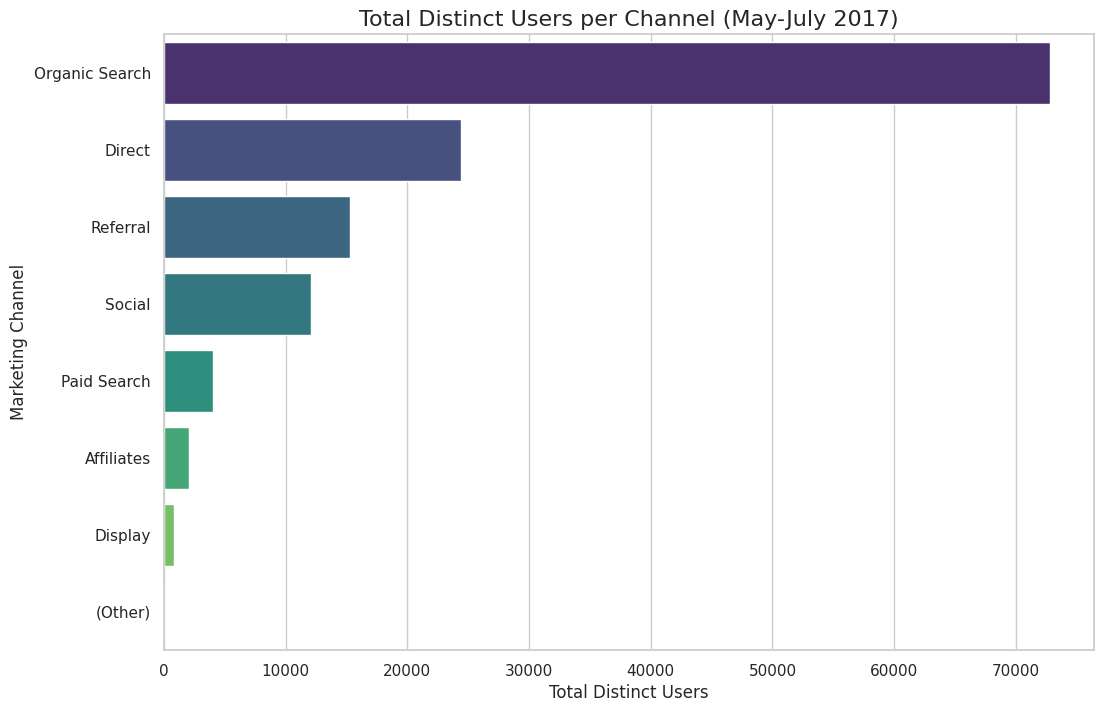

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style for a professional look
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x="total_distinct_users",
    y="channelGrouping",
    data=df_federated_result.sort_values("total_distinct_users", ascending=False),
    palette="viridis"
)

# Add title and labels for clarity
plt.title("Total Distinct Users per Channel (May-July 2017)", fontsize=16)
plt.xlabel("Total Distinct Users", fontsize=12)
plt.ylabel("Marketing Channel", fontsize=12)

# Display the plot
plt.show()


**Visualize: Monthly Users by Device**

This grouped bar chart allows for a month-over-month comparison of user traffic by device type. It's useful for identifying trends, such as the growth of mobile traffic over time, and understanding how the user base is segmented.

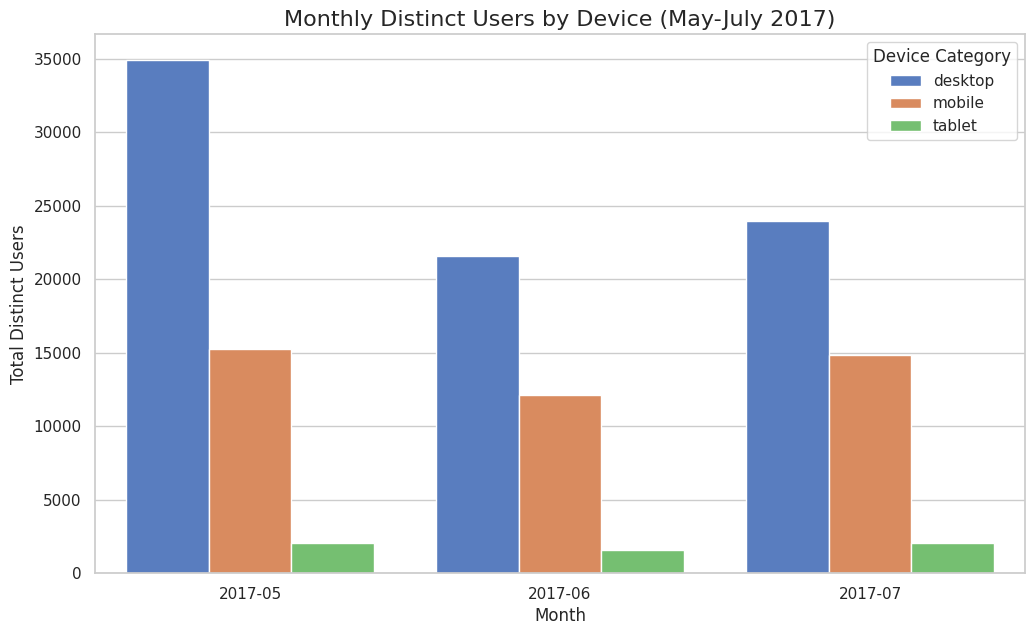

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x="month",
    y="total_distinct_users",
    hue="device_category",
    data=df_device_result,
    palette="muted"
)

# Add title and labels
plt.title("Monthly Distinct Users by Device (May-July 2017)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Distinct Users", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Device Category")

# Display the plot
plt.show()

**Visualize: Daily Revenue Trend**

A line chart is the ideal way to visualize time-series data like daily revenue. This plot makes it easy to spot trends, seasonality, and specific days with unusually high or low revenue across the three-month period.

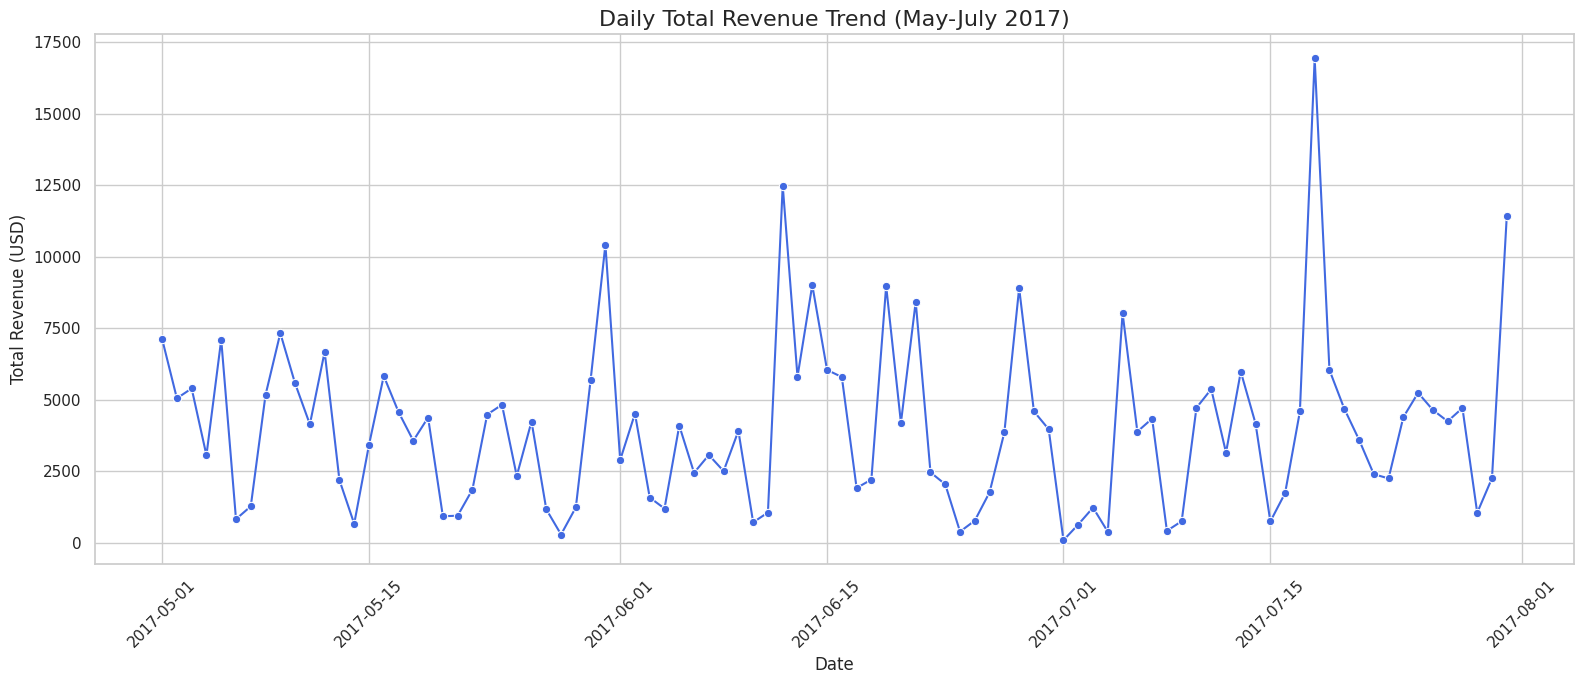

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the date column is in datetime format for proper plotting
df_revenue_result['transaction_date'] = pd.to_datetime(df_revenue_result['transaction_date'])

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the line plot
plt.figure(figsize=(16, 7))
sns.lineplot(
    x="transaction_date",
    y="daily_revenue_USD",
    data=df_revenue_result,
    marker="o",
    color="royalblue"
)

# Add title and labels
plt.title("Daily Total Revenue Trend (May-July 2017)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Revenue (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

---

## **Part 4: Cleanup (Optional)**

It's a best practice to clean up cloud resources you are no longer using to avoid incurring unnecessary costs. The following cells provide commands to delete the Cloud SQL instance, Spanner instance, GCS bucket, BigQuery dataset, and connections created in this notebook.

### Option A: Cleanup Cloud SQL Resources

Run this cell if you completed the Cloud SQL workflow (Part 1).

In [36]:
# Delete the BigQuery Connection for Cloud SQL
print(f"Deleting BigQuery connection '{BQ_CLOUDSQL_CONNECTION}'...")
!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_CLOUDSQL_CONNECTION}

# Delete the Cloud SQL Instance
print(f"\nDeleting Cloud SQL instance '{MYSQL_INSTANCE}'...")
!gcloud sql instances delete {MYSQL_INSTANCE} --quiet

print("\nCloud SQL cleanup complete.")

Deleting BigQuery connection 'bq-cloudsql-connection'...

Deleting Cloud SQL instance 'cloudsql-mysql-instance'...
Deleted [https://sqladmin.googleapis.com/sql/v1beta4/projects/arg-dev-mu/instances/cloudsql-mysql-instance].

Cloud SQL cleanup complete.


### Option B: Cleanup Spanner Resources

Run this cell if you completed the Spanner workflow (Part 2).

In [37]:
# Delete the BigQuery Connection for Spanner
print(f"Deleting BigQuery connection '{BQ_SPANNER_CONNECTION}'...")
!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_SPANNER_CONNECTION}

# Delete the Spanner Instance (which also deletes the database)
print(f"\nDeleting Spanner instance '{SPANNER_INSTANCE}'...")
!gcloud spanner instances delete {SPANNER_INSTANCE} --quiet

print("\nSpanner cleanup complete.")

Deleting BigQuery connection 'bq-spanner-connection'...

Deleting Spanner instance 'spanner-instance-template'...

Spanner cleanup complete.


### Option C: Cleanup All Resources

Uncomment and run this cell if you completed both Part 1 and Part 2. It also removes the shared GCS bucket and BigQuery dataset.

In [38]:
"""
# --- Cloud SQL Resources ---
print(f"Deleting BigQuery connection '{BQ_CLOUDSQL_CONNECTION}'...")
!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_CLOUDSQL_CONNECTION}
print(f"Deleting Cloud SQL instance '{MYSQL_INSTANCE}'...")
!gcloud sql instances delete {MYSQL_INSTANCE} --quiet

# --- Spanner Resources ---
print(f"\nDeleting BigQuery connection '{BQ_SPANNER_CONNECTION}'...")
!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_SPANNER_CONNECTION}
print(f"Deleting Spanner instance '{SPANNER_INSTANCE}'...")
!gcloud spanner instances delete {SPANNER_INSTANCE} --quiet

# --- Shared Resources ---
print(f"\nDeleting GCS bucket '{GCS_IMPORT_BUCKET}'...")
!gcloud storage rm -r {GCS_IMPORT_BUCKET}
print(f"Deleting BigQuery dataset '{BQ_FEDERATED_DATASET}'...")
!bq rm -r -f --dataset {PROJECT_ID}:{BQ_FEDERATED_DATASET}

print("\nFull cleanup complete.")
"""

'\n# --- Cloud SQL Resources ---\nprint(f"Deleting BigQuery connection \'{BQ_CLOUDSQL_CONNECTION}\'...")\n!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_CLOUDSQL_CONNECTION}\nprint(f"Deleting Cloud SQL instance \'{MYSQL_INSTANCE}\'...")\n!gcloud sql instances delete {MYSQL_INSTANCE} --quiet\n\n# --- Spanner Resources ---\nprint(f"\nDeleting BigQuery connection \'{BQ_SPANNER_CONNECTION}\'...")\n!bq rm --connection -f {PROJECT_ID}.{LOCATION}.{BQ_SPANNER_CONNECTION}\nprint(f"Deleting Spanner instance \'{SPANNER_INSTANCE}\'...")\n!gcloud spanner instances delete {SPANNER_INSTANCE} --quiet\n\n# --- Shared Resources ---\nprint(f"\nDeleting GCS bucket \'{GCS_IMPORT_BUCKET}\'...")\n!gcloud storage rm -r {GCS_IMPORT_BUCKET}\nprint(f"Deleting BigQuery dataset \'{BQ_FEDERATED_DATASET}\'...")\n!bq rm -r -f --dataset {PROJECT_ID}:{BQ_FEDERATED_DATASET}\n\nprint("\nFull cleanup complete.")\n'